# 데이터 불러오기 및 시각화

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
}

train_dataset = ImageFolder("/content/drive/MyDrive/Colab Notebooks/아이펠/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/drive/MyDrive/Colab Notebooks/아이펠/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)


이미지 변환은 이미지 데이터의 크기를 256x256으로 조절한 후, 224x224로 중앙 자르기를 수행한다.  
VGG-16 모델은 224x224 크기의 이미지로 학습한 모델이므로 입력 이미지의 크기도 224x224 크기로 변형해야 한다.  
<br>
탐지하려는 객체가 중앙에 위치할 확률이 높으므로 불필요한 지역 특징을 제거하기 위해 224x224 크기보다 더 큰 이미지 크기로 조절하고 자르기를 수행한다.

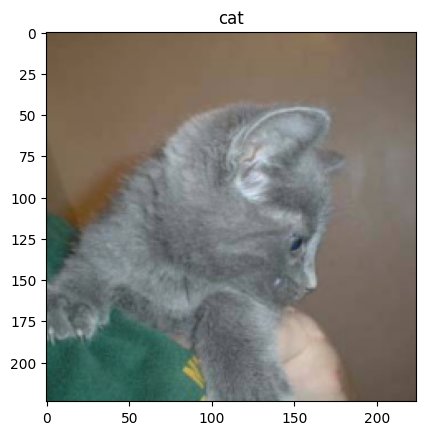

In [2]:
import numpy as np
from matplotlib import pyplot as plt


mean=[0.48235, 0.45882, 0.40784]
std=[0.229, 0.224, 0.225]

images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
    image = image.numpy().transpose((1, 2, 0))
    image = ((std * image + mean) * 255).astype(np.uint8)

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    break

이미지 변환을 통해 변경된 이미지는 텐서 변환 클래스(ToTensor)를 통해 PIL.Image(ndarray) 객체가 아닌 Tensor 객체로 변환됐다.  
Tesnor 객체는 이미지 형태를 (H, W, C)에서 (C, H, W)로 변환하므로 다시 (H, W, C) 형태로 변환해야 한다.  

# VGG-16

### 모델 불러오기 및 계층 구조 출력

In [3]:
from torchvision import models

model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 187MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

모델 정보를 보니 크게 fetures, avgpooling, classifier로 구성된 것을 확인할 수 있다.  
분류기 계층의 마지막 선형 변환을 보면 out_fetures로 총 1000개를 반환한다.  
이 값은 모델이 분류하는 카테고리의 개수를 의미한다.

### 미세 조정 및 모델 학습
현재 모델은 1,000개의 클래스가 아닌, 2개의 클래스를 대상으로 분류한다.  
그러므로 마지막 계층의 출력 특징을 2개로 변경해야 한다.

In [4]:
# VGG-16 미세 조정
from torch import nn

model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

분류기의 6번째 선형 계층에 접근한다.  
새로 학습하려는 계층은 1,000개의 클래스가 아닌 2개의 클래스를 학습할 예정이므로 출력 데이터의 차원 크기에 train_dataset의 클래스 개수를 입력한다.  
<br>
계층 자체를 변경하거나 계층의 매개변수를 변경한다면 사전에 학습된 가주잋를 적용할 수 없으므로 새로운 가중치를 학습해야 한다.  
VGG-16 모델의 매개변수를 수정했으므로 소규모 데이터세트로 학습을 진행한다.

아래 코드는 미세 조정된 VGG-16 모델을 학습하고 acc@1을 계산하는 방식이다.

In [13]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/아이펠/pet" "/content/pet"

In [14]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

# 하이퍼 파라미터 설정
hyperparams = {
    "batch_size": 16,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

# 데이터 로드
train_dataset = ImageFolder("/content/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True,
                             num_workers=2,  # 데이터 로딩 병목 완화,
                             pin_memory=True)  # GPU 메모리 전송 최적화
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True,
                             num_workers=2,  # 데이터 로딩 병목 완화,
                             pin_memory=True)  # GPU 메모리 전송 최적화)

In [15]:
# 모델 로드 및 미세 조정
model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

In [16]:
# 손실함수, 옵티마이저 정의 후 device 통일
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

In [17]:
# 모델 학습
for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")


Epoch :    1, Cost : 0.277
Epoch :    2, Cost : 0.092
Epoch :    3, Cost : 0.065
Epoch :    4, Cost : 0.051
Epoch :    5, Cost : 0.046


VGG-16 모델은 이미 개와 고양이 데이터로 사전 학습이 진행된 모델이므로 소규모의 데이터세트와 작은 에폭으로도 오차(cost)가 안정적으로 감소함을 확인할 수 있다.  
학습이 완료됐다면 테스트 데이터세트로 acc@1을 계산해 본다.

In [18]:
# 모델 평가
with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

acc@1 : 98.56%


acc@1은 상위 1개 레이블에 대한 정확도를 측정하므로 같음 비교 함수(torch.eq)로 테스트 데이터세트의 레이블과 모델 예측 결과를 비교한다.  
<br>
같음 비교 함수는 두 텐서의 값이 같다면 True를 반환하므로 sum해서 옳게 예측된 개수를 accuracy 변수에 누적합을 한다.  
<br>
accuracy 변수에 예측이 성공한 개수가 저장됐으므로 전체 데이터 개수를 나눠 테스트 데이터세트에 대한 예측 정확도를 계산한다.  
작은 소규모 데이터세트로도 모델이 안정적으로 학습된 것을 확인할 수 있다.

In [19]:
# 모델 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_practice/CV/models/VGG16.pt")
print("Saved the model weights")

Saved the model weights
